# Predicting house prices: a regression example

What we attempt here is to predict the median price of homes in a given Boston suburbin the mid-1970s. Τhis data set has only 506 data points, split between 404 training samples and 102 test samples. Also each feature in the input data has a different scale. For instance, some values are proportions, which take values between 0 and 1; others take values between 1 and 12, others between 0 and 100, and so on.

In [37]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [38]:
train_data.shape

(404, 13)

In [39]:
test_data.shape

(102, 13)

In [40]:
train_targets.shape

(404,)

The targets are the median values of owner-occupied homes, in thousands of
dollars:

In [41]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

## Prepearing the data

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), you subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation. This is easily done in Numpy.

In [42]:
import numpy as np

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /=std

Note that the quantities used for normalizing the test data are computed using the training data. You should never use in your workflow any quantity computed on the test data, even for something as simple as data normalization.

## Building the network

Because so few samples are available, you’ll use a very small network with two hidden layers, each with 64 units. In general, the less training data you have, the worse overfitting will be, and using a small network is one way to mitigate overfitting.

In [43]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64,activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1))

    model.compile(optimizer='rmsprop',
                 loss='mse',
                 metrics=['mae'])
    return model

The network ends with a single unit and no activation (it will be a linear layer). Here, because the last layer is purely linear, the network is free to learn to predict values in any range.

Note that you compile the network with the mse loss function—mean squared error, the square of the difference between the predictions and the targets. This is a widely used loss function for regression problems.

You’re also monitoring a new metric during training: mean absolute error (MAE). It’s the absolute value of the difference between the predictions and the targets.

## Validating our approach using K-fold validation

Becuase of the small size of the data the best practice in such situations is to use K-fold cross-validation. It consists of splitting the available data into K partitions (typically K = 4 or 5), instantiating K identical models, and training each one on K – 1 partitions while evaluating on the remaining partition. The validation score for the model used is then the average of
the K validation scores obtained.

In [44]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = np.zeros(k)

for i in range(k):
    print(f'processing fold: {i}')
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                        train_data[(i + 1) * num_val_samples:]],
                                       axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                        train_targets[(i + 1) * num_val_samples:]],
                                       axis=0)
    model = build_model()
    model.fit(partial_train_data,partial_train_targets,
             epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data,val_targets, verbose=0)
    all_scores[i] = val_mae

processing fold: 0
processing fold: 1
processing fold: 2
processing fold: 3


In [45]:
all_scores

array([2.00513887, 2.54184222, 2.56177211, 2.65950489])

In [46]:
np.mean(all_scores)

2.4420645236968994

Let’s try training the network a bit longer: 500 epochs. To keep a record of how well the model does at each epoch, you’ll modify the training loop to save the perepoch validation score log.

In [47]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print(f'processing fold: {i}')
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                        train_data[(i + 1) * num_val_samples:]],
                                       axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                        train_targets[(i + 1) * num_val_samples:]],
                                       axis=0)
    model = build_model()
    history = model.fit(partial_train_data,partial_train_targets,
                        validation_data=(val_data,val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold: 0
processing fold: 1
processing fold: 2
processing fold: 3


We can then compute the average of the per-epoch MAE scores for all folds.

In [48]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

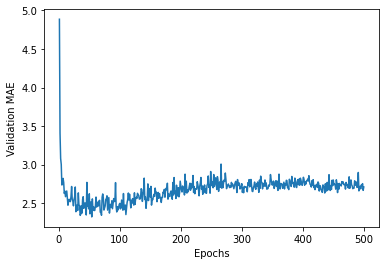

In [49]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It may be a little difficult to see the plot, due to scaling issues and relatively high variance.

Let’s do the following:
* Omit the first 10 data points, which are on a different scale than the rest of the curve.
* Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

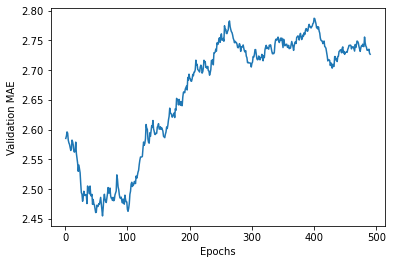

In [50]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, validation MAE stops improving significantly after 80 epochs. Past that point, you start overfitting.

After tuning all the parameters of the model (for example number of epochs or number of hidden layers) we train a final production model on all of the training data, with the best parameters, and then look at its perfomance on teh test data.

In [61]:
model = build_model()
model.fit(train_data,train_targets,epochs=100,batch_size=1,verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 12.1323 - mae: 2.4238


Final results.

In [62]:
test_mae_score

2.4238228797912598